In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import plotly.graph_objects as go
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_plotly, plot_components_plotly
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import operator
import numpy as np
from scipy import interpolate

from utils import *

In [2]:
from icecream import ic
ic.configureOutput(prefix = 'debug | -> ')

In [ ]:
ic.disable()
ic.enable()

## Codigos - Municipios

In [3]:
T = pd.read_csv("data/MunCodRel.csv")
Cod2Mun = {T.iloc[i, 3]:T.iloc[i, 1] for i in range(T.shape[0])}

## Uso doméstico

In [4]:
Domestico = pd.read_csv('data/consumo/Uso_Domestico_Consum_agrupat.csv')

In [5]:
Domestico.describe()

,Unnamed: 0,ID_CONTADOR,CONSUMO
count,9.971352e+06,9.971352e+06,9.971352e+06
mean,4.985676e+06,7.601747e+03,4.311951e+03
std,2.878482e+06,5.061552e+03,2.598006e+05
min,0.000000e+00,0.000000e+00,-6.146567e+07
25%,2.492838e+06,3.173000e+03,1.900000e+03
50%,4.985676e+06,7.096000e+03,3.394000e+03
75%,7.478513e+06,1.127400e+04,5.144000e+03
max,9.971351e+06,1.974600e+04,8.053108e+08


In [6]:
Domestico.columns

Index(['Unnamed: 0', 'ID_CONTADOR', 'CONSUMO', 'FECHA', 'Nom_Mun'], dtype='object')

In [7]:
Domestico.Nom_Mun.unique()

array(['BADALONA', 'BARCELONA', 'BEGUES', 'CASTELLDEFELS', 'CERDANYOLA',
       'CORNELLA', 'EL PAPIOL', 'ESPLUGUES', 'GAVA',
       'LES BOTIGUES SITGES', 'HOSPITALET LLOBR', 'MONTCADA I REIXAC',
       'MONTGAT', 'PALLEJA', 'SANT ADRIA', 'SANT BOI',
       'SANT CLIMENT LLOB', 'SANT FELIU LL', 'SANT JOAN DESPI',
       'SANT JUST DESVERN', 'STACOLOMA CERVELLO', 'STACOLOMA GRAMENET',
       'TORRELLES LLOBREGAT', 'VILADECANS'], dtype=object)

In [8]:
Cod2Mun

{8200: 'SANT BOI',
 8289: 'TORRELLES LLOBREGAT',
 8015: 'BADALONA',
 8089: 'GAVA',
 8073: 'CORNELLA',
 8301: 'VILADECANS',
 8020: 'BEGUES',
 8101: 'HOSPITALET LLOBR',
 8077: 'ESPLUGUES',
 8157: 'PALLEJA',
 8126: 'MONTGAT',
 8217: 'SANT JOAN DESPI',
 8205: 'SANT CUGAT',
 8056: 'CASTELLDEFELS',
 8266: 'CERDANYOLA',
 8245: 'STACOLOMA GRAMENET',
 8194: 'SANT ADRIA',
 8105: 'LA LLAGOSTA',
 8204: 'SANT CLIMENT LLOB',
 8211: 'SANT FELIU LL',
 8221: 'SANT JUST DESVERN',
 8158: 'EL PAPIOL',
 8019: 'BARCELONA',
 8270: 'LES BOTIGUES SITGES',
 8244: 'STACOLOMA CERVELLO',
 8125: 'MONTCADA I REIXAC',
 8904: 'BADIA',
 8282: 'TIANA',
 8187: 'SABADELL',
 8180: 'RIPOLLET'}

In [9]:
Domestico = Domestico.groupby(['FECHA', 'Nom_Mun']).CONSUMO.mean()

In [10]:
Domestico

FECHA       Nom_Mun            
2019-01-01  BADALONA                5309.000000
            BARCELONA               3035.744316
            BEGUES                  4382.947331
            CASTELLDEFELS           4181.961827
            CERDANYOLA             31174.000000
                                       ...     
2021-12-01  SANT JUST DESVERN       3696.324056
            STACOLOMA CERVELLO      3970.315364
            STACOLOMA GRAMENET      3470.583610
            TORRELLES LLOBREGAT     4351.547441
            VILADECANS              3617.966365
Name: CONSUMO, Length: 1656, dtype: float64

### Analizando la tendencia general de consumo doméstico

In [11]:
Domestico = pd.DataFrame([np.array(list(Domestico.to_dict().keys())).T[0], 
 np.array(list(Domestico.to_dict().keys())).T[1], 
 np.array(list(Domestico.to_dict().values())) ]).T

Domestico.columns = ['ds', 'mun', 'y']
Domestico.head()

,ds,mun,y
0,2019-01-01,BADALONA,5309.0
1,2019-01-01,BARCELONA,3035.744316
2,2019-01-01,BEGUES,4382.947331
3,2019-01-01,CASTELLDEFELS,4181.961827
4,2019-01-01,CERDANYOLA,31174.0


In [12]:
DomesticoF = Domestico.query("mun != 'CERDANYOLA'")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


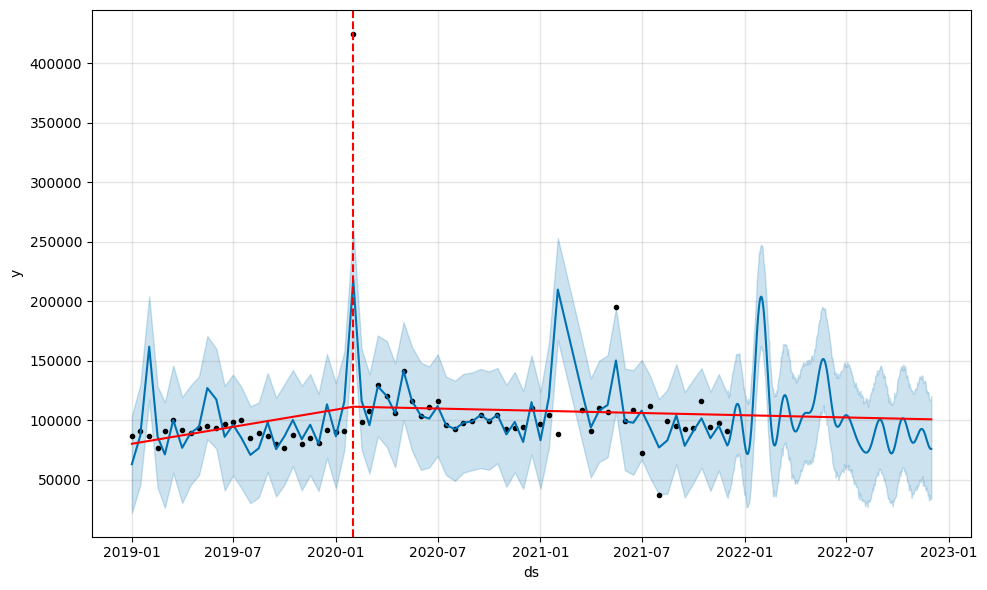

In [151]:
#np.array(Domestico.groupby("ds").y.mean())
TendencyConsumtion = pd.DataFrame([pd.DataFrame(DomesticoF.groupby("ds").y.sum()).index, np.array(DomesticoF.groupby("ds").y.sum())]).T
TendencyConsumtion.columns = ['ds', 'y']
analyze(TendencyConsumtion, name = 'Uso doméstico global', gt_0 = 0, max_ = None, prior = 0.05, monthly = True)

In [93]:
f = px.bar(Domestico.groupby("mun").y.mean().sort_values(ascending=False)[:])
f.update_layout(title = "Consumo por municipios", yaxis_title = r'$m^3$', xaxis_title = 'Municipios')

In [94]:
Domestico.groupby("mun").y.mean().sort_values(ascending=False)[:10]

mun
CERDANYOLA             13259.728452
STA.COLOMA CERVELLO     7341.072157
STA.COLOMA GRAMENET     6283.826750
PALLEJA                 5345.899502
BEGUES                  5225.261092
ESPLUGUES               5207.436173
CASTELLDEFELS           5091.813345
GAVA                    5034.105291
TORRELLES LLOBREGAT     4913.003258
SANT FELIU LL           4833.132157
Name: y, dtype: float64

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


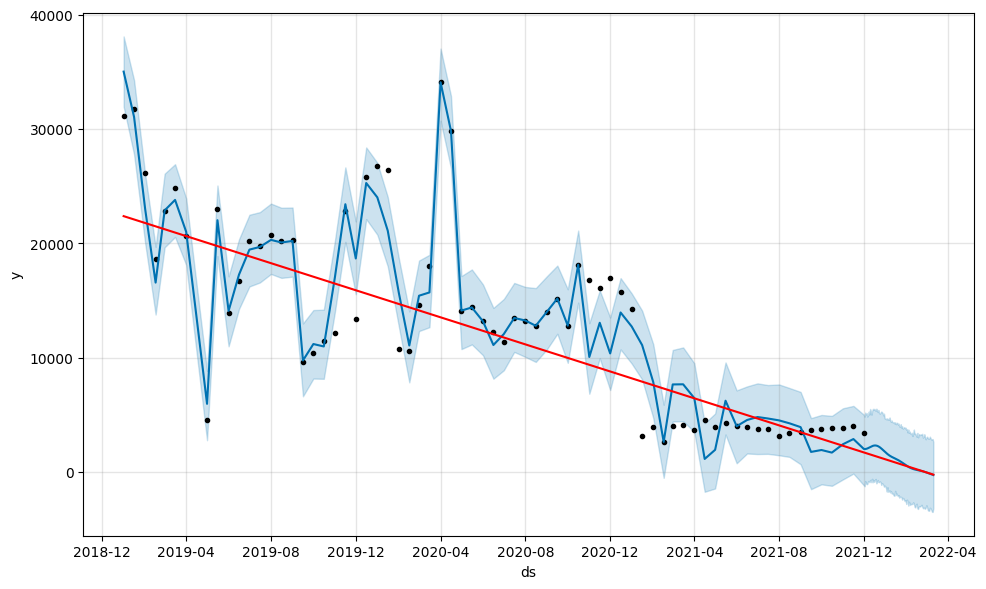

In [95]:
Temp = Domestico.query("mun == 'CERDANYOLA'")[['ds', 'y']]
analyze(Temp, name = 'Uso doméstico Barcelona', gt_0 = 2_500, max_ = None, prior = 0.01, monthly = True, days = 100)

## Uso doméstico y población

In [13]:
pob = pd.read_csv("data/poblacionHistorico_ABData.csv")
vectemp = []
for i in pob.cod_mun:
    vectemp.append(Cod2Mun[i])
pob['municipio'] = vectemp
pob.head()

,Unnamed: 0,cod_mun,intervalo_edat,value,Genero,year,municipio
0,0,8077,juvenil,74.0,hombre,2015,ESPLUGUES
1,1,8019,juvenil,57.0,hombre,2015,BARCELONA
2,2,8187,juvenil,51.0,hombre,2015,SABADELL
3,3,8101,juvenil,75.0,hombre,2015,HOSPITALET LLOBR
4,4,8019,juvenil,58.0,hombre,2015,BARCELONA


## Ver cuales están subiendo su población más rápido

In [102]:
pob_change = {}
for mun in pob.municipio.unique():
    pob_change[mun] = pob.query(f"municipio == '{mun}' and year == 2020").value.sum()/ \
                      pob.query(f"municipio == '{mun}' and year == 2015").value.sum()

In [104]:
np.array(sorted(pob_change.items(), key=operator.itemgetter(1), reverse=True))

array([['SANT JUST DESVERN', '1.1226023690698095'],
       ['BEGUES', '1.0944527736131935'],
       ['MONTCADA I REIXAC', '1.0705704395380633'],
       ['HOSPITALET LLOBR', '1.0682513056616343'],
       ['TIANA', '1.0634882891451671'],
       ['MONTGAT', '1.0607773237109817'],
       ['SANT CUGAT', '1.058601844472276'],
       ['CASTELLDEFELS', '1.055860762861749'],
       ['RIPOLLET', '1.0463079182801442'],
       ['SANT ADRIA', '1.0455966940302674'],
       ['LES BOTIGUES SITGES', '1.0454207789451342'],
       ['SABADELL', '1.041893231447352'],
       ['CORNELLA', '1.0412151523571362'],
       ['SANT FELIU LL', '1.0380593607305937'],
       ['BARCELONA', '1.0371610820445545'],
       ['SANT CLIMENT LLOB', '1.0366309494144033'],
       ['BADALONA', '1.0348335760060097'],
       ['ESPLUGUES', '1.0334020076272301'],
       ['TORRELLES LLOBREGAT', '1.032296447390787'],
       ['STACOLOMA CERVELLO', '1.030665669409125'],
       ['SANT JOAN DESPI', '1.0301527176527177'],
       ['STACOLOMA

In [32]:
pob.query("municipio == 'EL PAPIOL'").groupby(["municipio", "year"]).sum()

Unnamed: 0  cod_mun   value
municipio year                             
EL PAPIOL 2015      153868   130528  4071.0
          2016      433244   130528  4075.0
          2017      712212   130528  4102.0
          2018      990872   130528  4103.0
          2019     1270204   130528  4145.0
          2020     1548860   130528  4172.0

In [34]:
Domestico.query(f"mun == 'EL PAPIOL'")[['ds', 'y']] 

,ds,y
6,2019-01-01,3954.660079
29,2019-01-16,4109.669819
52,2019-02-01,3928.116627
75,2019-02-16,3503.32783
98,2019-03-01,4055.4107
...,...,...
1542,2021-10-01,4101.091087
1566,2021-10-16,4485.592807
1590,2021-11-01,4166.923323
1614,2021-11-16,4201.913127


In [16]:
Poblacion = pob.groupby(["municipio", "year"]).sum()
RatioPobConsumo = {}
for mun in Domestico.groupby("mun").y.mean().sort_values(ascending=False)[:].index:
    #mun = 'CASTELLDEFELS'
    f = interpolate.interp1d(Poblacion.value[mun].index, 
                             Poblacion.value[mun].values, 
                             fill_value = 'extrapolate')

    T = Domestico.query(f"mun == '{mun}'")[['ds', 'y']] 
    for year in [2020, 2021, 2022]:
        T.loc[np.array(T.ds > f'{year - 1}') * np.array(T.ds < f'{year}'), "y"] =  \
                    T.loc[np.array(T.ds > f'{year-1}')* np.array(T.ds < f'{year}'), "y"] / f(year - 1) * 1_000

    lower, upper = ic(CalculateFences(T))

    T = T[T.y > lower]
    T = T[T.y < upper]
    
    RatioPobConsumo[mun] = T.y.mean()
    #analyze(T, name = f'Uso doméstico {mun}', gt_0 = lower, max_ = upper, prior = 0.01, monthly = True, days = 100)

debug | -> CalculateFences(T): (0, 733.0)
debug | -> CalculateFences(T): (0, 1873.5)
debug | -> CalculateFences(T): (0, 137.5)
debug | -> CalculateFences(T): (249.0, 433.0)
debug | -> CalculateFences(T): (447.5, 923.5)
debug | -> CalculateFences(T): (62.0, 102.0)
debug | -> CalculateFences(T): (60.0, 92.0)
debug | -> CalculateFences(T): (62.5, 106.5)
debug | -> CalculateFences(T): (413.5, 1057.5)
debug | -> CalculateFences(T): (61.0, 101.0)
debug | -> CalculateFences(T): (6.5, 26.5)
debug | -> CalculateFences(T): (671.0, 1295.0)
debug | -> CalculateFences(T): (779.0, 1315.0)
debug | -> CalculateFences(T): (175.0, 279.0)
debug | -> CalculateFences(T): (201.0, 473.0)
debug | -> CalculateFences(T): (85.5, 137.5)
debug | -> CalculateFences(T): (85.0, 125.0)
debug | -> CalculateFences(T): (73.5, 125.5)
debug | -> CalculateFences(T): (10.5, 14.5)
debug | -> CalculateFences(T): (11.5, 71.5)
debug | -> CalculateFences(T): (25.0, 81.0)
debug | -> CalculateFences(T): (0, 3.5)
debug | -> Calculat

In [49]:
RatioPobConsumo_sorted = np.array(sorted(RatioPobConsumo.items(), key=operator.itemgetter(1), reverse=True))

In [58]:
f = px.bar(x = RatioPobConsumo_sorted.T[0], y = np.float32(RatioPobConsumo_sorted.T[1]))
f.update_layout(title = "Consumo por habitante", yaxis_title = 'Litros', xaxis_title = 'Municipio')

In [83]:
RatioPobConsumo_sorted.T[0][:]

array(['EL PAPIOL', 'SANT CLIMENT LLOB', 'STACOLOMA CERVELLO',
       'TORRELLES LLOBREGAT', 'BEGUES', 'PALLEJA', 'MONTGAT',
       'LES BOTIGUES SITGES', 'CERDANYOLA', 'SANT JUST DESVERN',
       'SANT JOAN DESPI', 'MONTCADA I REIXAC', 'SANT ADRIA', 'GAVA',
       'ESPLUGUES', 'SANT FELIU LL', 'CASTELLDEFELS', 'VILADECANS',
       'STACOLOMA GRAMENET', 'SANT BOI', 'CORNELLA', 'BADALONA',
       'HOSPITALET LLOBR', 'BARCELONA'], dtype='<U32')

In [ ]:
# EL PAPIOL ha subido bastante
# SANT CLIMENT LLOB ha subido bastante
# STACOLOMA CERVELLO no representa nada por falta de mediciones
# TORRELLES LLOBREGAT subidas importantes
# BEGUES se ha reducido inclusive
# PALLEJA incrementos notables
# MONTGAT ha subido un poco
# LES BOTIGUES SITGES no aparenta tener cambios significativos
# Cerdanyola parecería tener una tendencia muy marcada a la reducción
# SANT JUST DESVERN no aparente tener cambios significativos
# SANT JOAN DESPI ligeras subidas



# Barcelona representa una tendencia creciente en el consumo con respecto a su población de 1.9 a 2.3
# 

debug | -> mun: 'BADALONA'
debug | -> CalculateFences(T): (6.5, 26.5)
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


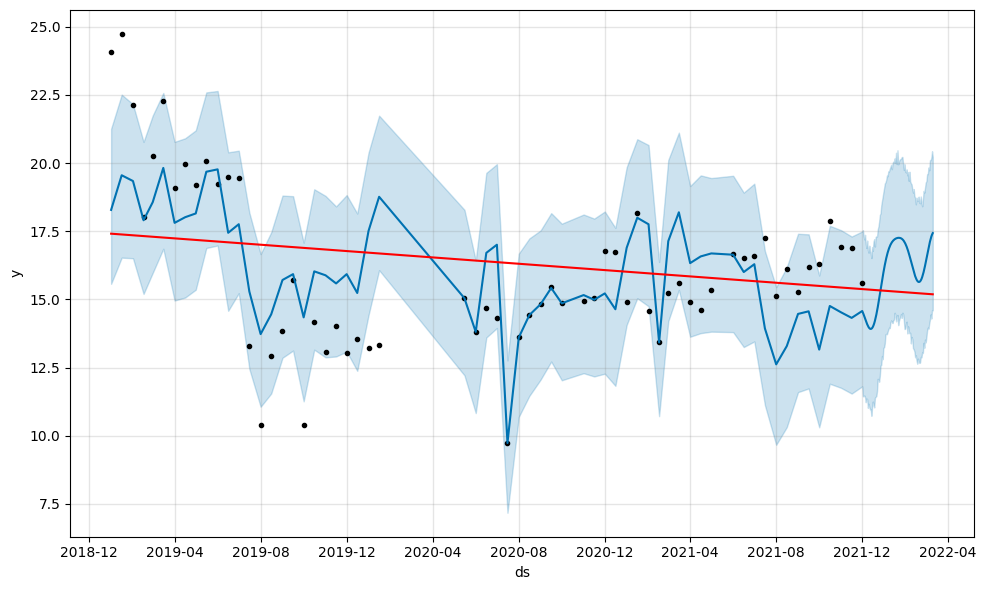

In [85]:
Poblacion = pob.groupby(["municipio", "year"]).sum()

mun = RatioPobConsumo_sorted.T[0][-3]

ic(mun)

f = interpolate.interp1d(Poblacion.value[mun].index, 
                         Poblacion.value[mun].values, 
                         fill_value = 'extrapolate')

T = Domestico.query(f"mun == '{mun}'")[['ds', 'y']] 
for year in [2020, 2021, 2022]:
    T.loc[np.array(T.ds > f'{year - 1}') * np.array(T.ds < f'{year}'), "y"] =  \
                T.loc[np.array(T.ds > f'{year-1}')* np.array(T.ds < f'{year}'), "y"] / f(year - 1) * 1_000
                                                                

lower, upper = ic(CalculateFences(T))


analyze(T, name = f'Uso doméstico {mun}', gt_0 = lower, max_ = upper, prior = 0.01, monthly = True, days = 100)

## Consumo Actividad económica

In [3]:
Data = pd.read_csv("data/consumo/AEDataConsum_agrupat.csv")
Data.columns = ['Unnamed: 0', 'ID_CLIENTE', 'EPIGRAF', 'DESCP_EPIGRAF', 'CONSUMO',
       'FECHA', 'Nom_Mun']

Data['DESCP_EPIGRAF'] = Data['DESCP_EPIGRAF'].str.replace("'", "")

In [4]:
Data.head()

,Unnamed: 0,ID_CLIENTE,EPIGRAF,DESCP_EPIGRAF,CONSUMO,FECHA,Nom_Mun
0,0,112,I6911,Reparació articles elèctrics per la llar,7961,2019-01-01,BADALONA
1,1,154,I8612,* de locals industrials i altres lloguers,30253,2019-01-01,BADALONA
2,2,154,I9411,Hospitals generals,30253,2019-01-01,BADALONA
3,3,154,I9421,"Consultoris mèdics, centres de socors, sanitaris",30253,2019-01-01,BADALONA
4,4,154,IAJT,SUBMINISTRAMENTS DAJUNTAMENT,30253,2019-01-01,BADALONA


In [5]:
F = Data['DESCP_EPIGRAF'].unique()
F.sort()
F

array(['* Accessoris del vestit i altres productes tèx',
       '* Accessoris, parts i peces daparells electrod',
       '* Activitats annexes (tapisseria, envernissat,',
       '* Altres articles de cautxú n.c.a.a.',
       '* Altres articles de consum durable n.c.a.a.',
       '* Altres articles n.c.a.a.',
       '* Altres articles per envasos i embalatge de p',
       '* Altres equipaments, etc., (excepte equip elèc',
       '* Altres indústries tèxtil n.c.a.a.',
       '* Altres productes alimentaris n.c.a.a.',
       '* Altres productes alimentaris, gelats, etc.',
       '* Altres productes inter-industrials (excepte',
       '* Altres productes inter-industrials n.c.a.a.',
       '* Altres serveis dalimentació propis de la res',
       '* Aparells electrodomèstics i ferreteria',
       '* Aparells elèctrics per la conservació de la l',
       '* Aparells i materials radioelèctric i electrò',
       '* Articles acabats de matèries plàstiques',
       '* Articles tèxtils per la lla

In [15]:
# Encontrando aquellos con mayor consumo
Con = Data.groupby("DESCP_EPIGRAF").CONSUMO.mean()
Con.sort_values(ascending=False)[:10]

DESCP_EPIGRAF
Balnearis i banys                                     4.094739e+06
Serveis de sanejament de vivers públiques i simila    2.674167e+06
Fabricació de mobiliari metàl·lic                     1.656059e+06
Producció denergia termoelèctrica convencional        1.656059e+06
Fabricació destructures metàl·liques                  1.656059e+06
Hospitals, clíniques i sanatoris de medicina human    1.569624e+06
Hospitals generals                                    1.464082e+06
* de segona classe                                    1.286629e+06
* i museus                                            1.221578e+06
* en sales i locals                                   1.003366e+06
Name: CONSUMO, dtype: float64

15:34:43 - cmdstanpy - INFO - Chain [1] start processing
15:34:44 - cmdstanpy - INFO - Chain [1] done processing


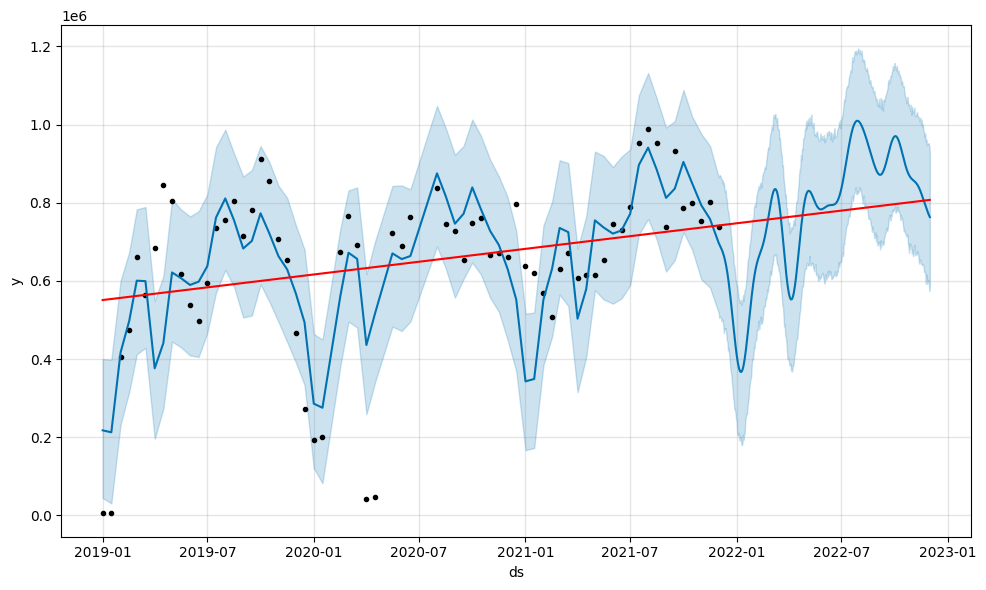

In [20]:
Temp = Data.query("DESCP_EPIGRAF == '* i museus'")[['FECHA', 'CONSUMO']]
Temp.columns = ['ds', 'y']
analyze(Temp, name = 'Balnearios', gt_0 = True, max_ = 1e6)

## Precio del Agua

In [7]:
precio_agua = pd.read_csv("data/precio_agua.csv")
precio_agua.head()

,anio,fecha_inicio,fecha_final,suministro_min,suministro_max,tipo,precio
0,2018,11/05/2018,31/12/2019,0,6.0,doméstico,0.6087
1,2018,11/05/2018,31/12/2019,7,9.0,doméstico,1.2175
2,2018,11/05/2018,31/12/2019,10,15.0,doméstico,1.8262
3,2018,11/05/2018,31/12/2019,16,18.0,doméstico,2.4349
4,2018,11/05/2018,31/12/2019,18,inf,doméstico,3.0436


In [8]:
precio_agua.query("suministro_min == 18 and tipo == 'doméstico'")

,anio,fecha_inicio,fecha_final,suministro_min,suministro_max,tipo,precio
4,2018,11/05/2018,31/12/2019,18,inf,doméstico,3.0436
9,2020,01/01/2020,03/08/2021,18,inf,doméstico,2.9246
14,2021,04/08/2021,31/12/2021,18,inf,doméstico,2.9705


## Renta

In [9]:
renta = pd.read_csv("data/trenta_municipalABData.csv")
renta.sort_values(by = ['Renta neta media por hogar'])

,Unnamed: 0,nom_mun,cod_mun,Renta neta media por hogar,rank
29,29,Badia del Vallès,8904,28239.0,1
23,23,Santa Coloma de Gramenet,8245,29891.0,1
15,15,Sant Adrià de Besòs,8194,31090.0,1
7,7,"Hospitalet de Llobregat, L'",8101,31358.0,1
8,8,"Llagosta, La",8105,31718.0,1
13,13,Ripollet,8180,33645.0,1
0,0,Badalona,8015,33689.0,1
4,4,Cornellà de Llobregat,8073,33806.0,1
9,9,Montcada i Reixac,8125,34324.0,2
14,14,Sabadell,8187,35249.0,2


## Población

Hacen falta datos históricos de la población para poder predecir

In [10]:
pob = pd.read_csv("data/tpob_municipalABData.csv")
vectemp = []
for i in pob.cod_mun:
    vectemp.append(Cod2Mun[i])
pob['municipio'] = vectemp

In [11]:
pobmean = pob.groupby("municipio").mean()
pobmean.sort_values(by = ['value'])

,Unnamed: 0,cod_mun,value
municipio,,,
BADIA,6401.083333,8904.0,142.645833
STA.COLOMA GRAMENET,7045.215909,8245.0,173.056818
SABADELL,7069.018987,8187.0,175.841772
CORNELLA,6909.423077,8073.0,178.130769
L'HOSPITALET LLOBR.,6979.115385,8101.0,178.324359
VILADECANS,7052.500000,8301.0,188.700000
TORRELLES LLOBREGAT,7432.500000,8289.0,190.750000
LA LLAGOSTA,7076.611111,8105.0,191.555556
SANT FELIU LL.,6880.500000,8211.0,194.691667


## GINI

In [12]:
gini = pd.read_csv("data/tgini_ABData.csv")
gini['Índice de Gini'] = gini['Índice de Gini'].str.replace(",", ".")
gini['Índice de Gini'] = gini['Índice de Gini'].astype("float")
gini['nom_mun'] = gini['nom_mun'].str.replace("'", "")
#gini.Periodo = gini.Periodo.astype("str")
#gini.Periodo = pd.to_datetime(gini.Periodo)
gini

,Unnamed: 0,cod_mun,nom_mun,Periodo,Distribución de la renta P80/P20,Índice de Gini
0,84,8015,Badalona,2015,"2,9",32.7
1,85,8015,Badalona,2016,"2,7",32.4
2,86,8015,Badalona,2017,"2,8",31.4
3,87,8015,Badalona,2018,"2,7",30.8
4,88,8015,Badalona,2019,"2,8",30.5
...,...,...,...,...,...,...
175,1855,8904,Badia del Vallès,2016,"2,3",27.8
176,1856,8904,Badia del Vallès,2017,"2,4",26.5
177,1857,8904,Badia del Vallès,2018,"2,3",25.5
178,1858,8904,Badia del Vallès,2019,"2,2",25.1


In [13]:
# Intrapolando los valores
Vec = []
for nom in gini.nom_mun.unique():
    temp = gini.query(f"nom_mun== '{nom}'")

    for i in range(temp.shape[0]):
            if (i + 1) == temp.shape[0]:
                continue
            Cambio = (temp.iloc[i + 1, 5] - temp.iloc[i, 5])/12
            anio = str(temp.iloc[i, 3])
            for j in range(11):
                Vec.append([temp.iloc[i, 0], temp.iloc[i, 1], temp.iloc[i, 2] , anio + f"-{j+2}-1", 0, temp.iloc[i, 5] + Cambio*(j+1)])


In [14]:
Vec = pd.DataFrame(Vec)
Vec.columns = gini.columns

gini = pd.concat([Vec, gini])
gini.Periodo = gini.Periodo.astype("str")
gini.Periodo = pd.to_datetime(gini.Periodo)
gini

,Unnamed: 0,cod_mun,nom_mun,Periodo,Distribución de la renta P80/P20,Índice de Gini
0,84,8015,Badalona,2015-02-01,0,32.675
1,84,8015,Badalona,2015-03-01,0,32.650
2,84,8015,Badalona,2015-04-01,0,32.625
3,84,8015,Badalona,2015-05-01,0,32.600
4,84,8015,Badalona,2015-06-01,0,32.575
...,...,...,...,...,...,...
175,1855,8904,Badia del Vallès,2016-01-01,"2,3",27.800
176,1856,8904,Badia del Vallès,2017-01-01,"2,4",26.500
177,1857,8904,Badia del Vallès,2018-01-01,"2,3",25.500
178,1858,8904,Badia del Vallès,2019-01-01,"2,2",25.100


In [15]:
gini.query("nom_mun == 'Barcelona' and Periodo < '2017-02-01'").sort_values("Periodo")

,Unnamed: 0,cod_mun,nom_mun,Periodo,Distribución de la renta P80/P20,Índice de Gini
6,108,8019,Barcelona,2015-01-01,"3,2",36.800000
55,108,8019,Barcelona,2015-02-01,0,36.816667
56,108,8019,Barcelona,2015-03-01,0,36.833333
57,108,8019,Barcelona,2015-04-01,0,36.850000
58,108,8019,Barcelona,2015-05-01,0,36.866667
59,108,8019,Barcelona,2015-06-01,0,36.883333
60,108,8019,Barcelona,2015-07-01,0,36.900000
61,108,8019,Barcelona,2015-08-01,0,36.916667
62,108,8019,Barcelona,2015-09-01,0,36.933333
63,108,8019,Barcelona,2015-10-01,0,36.950000


18:49:24 - cmdstanpy - INFO - Chain [1] start processing
18:49:24 - cmdstanpy - INFO - Chain [1] done processing


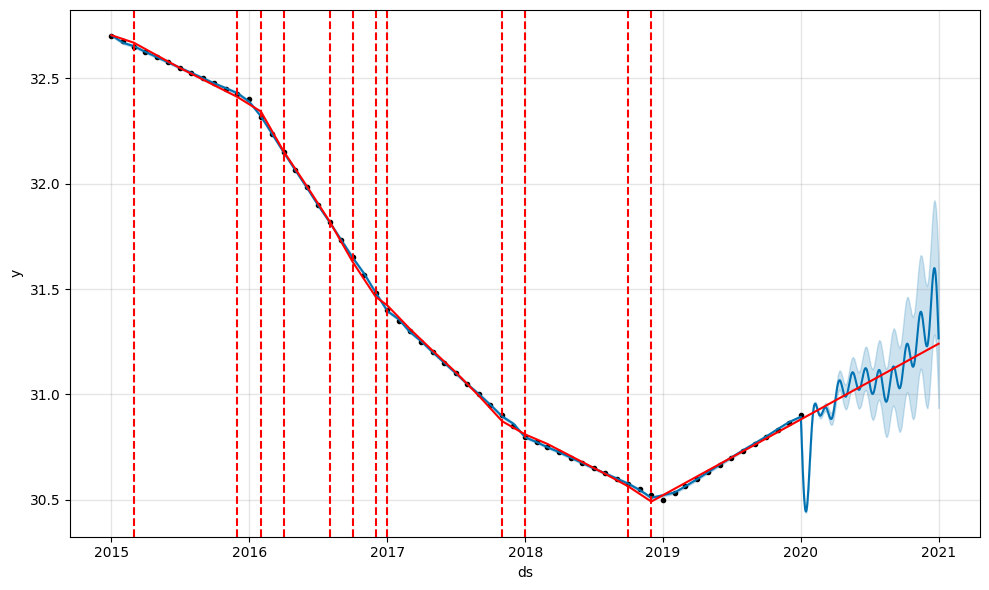

In [17]:
Temp = gini.query("nom_mun == 'Badalona'")[['Periodo', 'Índice de Gini']]
Temp.columns = ['ds', 'y']
analyze(Temp, name = 'Índice de gini', gt_0 = True, max_ = None)

In [22]:
holidays = pd.read_csv("data/Festius_generals_de_Catalunya.csv")
holidays = holidays.query("Any > 2018")
holidays = holidays[['Data', 'Nom del festiu']]
holidays.columns = ['ds', 'holiday']

m = Prophet(changepoint_prior_scale = 0.01, holidays = holidays, seasonality_mode='multiplicative')

In [23]:
holidays

,ds,holiday
99,2019-01-01,Cap d'Any
100,2019-04-19,Divendres Sant
101,2019-04-22,Dilluns de Pasqua Florida
102,2019-01-05,Festa del Treball
103,2019-06-24,Sant Joan
104,2019-08-15,L'Assumpció
105,2019-11-09,Diada Nacional de Catalunya
106,2019-12-10,Festa Nacional d'Espanya
107,2019-01-11,Tots Sants
108,2019-06-12,Dia de la Constitució


In [17]:
F = np.array([[20,100,24], [100,680, 100], [24, 100, 48.8]])
B = np.dot(np.linalg.inv(F), np.array([5, -225, 146]))

In [19]:
1201.25 - np.dot(B,np.array([5, -225, 146]))

144.375